
## Capstone Project "What's Happening in my Neighborhood"
by Lori Butler  

**Data Questions**
1. Which neighborhoods have had the most, and the least, growth during the past three years based on the count of building permits by type, and by cost of construction.
2. Do any neighborhoods have recent increases in building permit applications which may signal growth in the near future?


**Cleaned Files... What "cleaned" means**
- Columns renamed (kept all columns that had data; will subset them during EDA)
- Data types cleaned (datetime, ESPG)
- Used regex to extract lat/lon from mapped_location column
- Handled null values in lat/lon columns (dropped rows)
- Deleted rows that had "0" for house number in street address (new construction; no lat/lon available)
- Kept ONLY the rows related to growth:
    - Bldg Permit Applications & Permits Issued: Kept NEW residential or commercial bldg permits
    - Planning Dept: Kept REZONING 

In [44]:
import pandas as pd
import numpy as np
import geopandas as gpd   # Prerequisite: Activate geospatial environment via Conda Prompt
import matplotlib.pyplot as plt  
import folium                   
from folium.plugins import MarkerCluster
from shapely.geometry import Point  

# To create rolling dates to view past week, 30 days, etc.  (Not sure if I need this yet)
from datetime import timedelta  

In [45]:
# BLDG DEPT PERMIT APPLICATIONS
# Expecting: 996 rows, 15 columns  

df_bldg_apps_clean = pd.read_csv('../data/cleaned/bldg_permit_apps_clean_with_latlon_NEWonly.csv')
print(df_bldg_apps_clean.shape)
df_bldg_apps_clean.head(2)

(996, 15)


,permit_number,permit_type_descr,permit_subtype_descr,date_entered,construction_cost,address,city,state,zip,contact,ivr_tracking_number,purpose,lat,lon,category
0,T2020034761,Building Residential - New,Single Family Residence,2020-06-04,NaN,518 N 2ND ST,NASHVILLE,TN,37207,EASTEND CONTRACTING LLC,3830078,to construct 2034SF single family residence. 5...,36.180490,-86.771778,Residential
1,T2020034763,Building Residential - New,Detached Accessory Dwelling Unit,2020-06-04,NaN,516 2ND ST,NASHVILLE,TN,37207,EASTEND CONTRACTING LLC,3830086,to construct 624SF detached accessory dwelling...,36.180361,-86.771791,Residential


In [46]:
# BLDG DEPT PERMITS ISSUED
# Expecting: 10433 rows, 16 columns  

df_bldg_issued_clean = pd.read_csv('../data/cleaned/bldg_permits_issued_clean_with_latlon_NEWonly.csv')
print(df_bldg_issued_clean.shape)
df_bldg_issued_clean.head(2)

(10433, 16)


,permit_number,permit_type_descr,permit_subtype_descr,date_entered,date_issued,construction_cost,address,city,state,zip,contact,ivr_tracking_number,purpose,lat,lon,category
0,2020032483,Building Residential - New,Single Family Residence,2020-05-26,2020-06-04,185000.0,530 EDWIN ST 22,NASHVILLE,TN,37207,LEGACY SOUTH BUILDERS LLC,3823505,To construct unit 22 - CAUO 2019024656. for e...,36.203789,-86.755262,Residential
1,2020008317,Building Residential - New,Single Family Residence,2020-02-06,2020-06-04,290299.0,6982 OLD HICKORY BLVD,WHITES CREEK,TN,37189,Gregory Construction Group,3757633,New construction - Residential. parcel is zon...,36.269651,-86.841697,Residential


In [47]:
# PLANNING / ZONING DEPT APPLICATIONS AND ISSUED (rolling 2 mo on issued)
# Expecting: 86 rows, 18 columns

df_planning_clean = pd.read_csv('../data/cleaned/planning_dept_clean_with_latlon_REZONINGonly.csv')
print(df_planning_clean.shape)
df_planning_clean.head(2)

(86, 15)


,date_submitted,application_type_descr,mpc_case_number,ordinance_number,status,mpc_meeting_date,mpc_action,project_name,location,reviewer,case_descr,applicant,applicant_representative,latitude,longitude
0,2020-05-13,Rezoning,2020Z-079PR-001,NaN,NEW,2020-07-23,NaN,NaN,1924 9TH AVE N 37208,Jason Swaggart,A request to rezone from R6 to CS zoning for p...,Fulmer Engineering,Jackson LeBeau,36.184524,-86.803020
1,2020-05-26,Rezoning,2020Z-080PR-001,NaN,NEW,2020-07-23,NaN,NaN,5516 THALMAN DR 37027,FRONT COUNTER,"A request to rezone from R15, R20, and R40 to ...",Metro Council,Councilmember Robert Swope,36.048358,-86.757802


In [48]:
# DAVIDSON COUNTY BORDER GeoJSON folder

df_dav_border = gpd.read_file('../data/raw/Davidson County Border (GIS).geojson')
print(df_dav_border.shape)
df_dav_border.head(2)

(2, 5)


,area_sq_mi,objectid,shape_area,shape_len,geometry
0,525,4,14641027913.6,686109.334953,"MULTIPOLYGON (((-86.52704 36.13598, -86.52914 ..."
1,0,3,675823.52,3786.70930403,"MULTIPOLYGON (((-86.52315 36.13876, -86.52288 ..."


In [49]:
# NEIGHBORHOOD ASSOCIATION BOUNDARIES
# Expecting: 288 rows, 2 columns

df_na_bound_clean = gpd.read_file('../data/cleaned/neighborhood_association_boundaries_clean.shp')
print(df_na_bound_clean.shape)
df_na_bound_clean.head(2)

(288, 2)


,name,geometry
0,Historic Buena Vista,"POLYGON ((-86.79511 36.17576, -86.79403 36.176..."
1,Charlotte Park,"POLYGON ((-86.87460 36.15758, -86.87317 36.157..."


## Creating new 'type_subtype' column to use as popup on maps; in both full dfs 
Example: TYPE: Building Residential - New SUBTYPE: Single Family Residence   

In [50]:
# 
# Adding column to have single column for use in popup
# Adding to main df, then 

df_bldg_apps_clean['type_subtype'] = ("TYPE: "
                                + df_bldg_apps_clean['permit_type_descr'] 
                                + " SUBTYPE: " 
                                + df_bldg_apps_clean['permit_subtype_descr']
                               )
df_bldg_apps_clean.head(1)                          

,permit_number,permit_type_descr,permit_subtype_descr,date_entered,construction_cost,address,city,state,zip,contact,ivr_tracking_number,purpose,lat,lon,category,type_subtype
0,T2020034761,Building Residential - New,Single Family Residence,2020-06-04,NaN,518 N 2ND ST,NASHVILLE,TN,37207,EASTEND CONTRACTING LLC,3830078,to construct 2034SF single family residence. 5...,36.18049,-86.771778,Residential,TYPE: Building Residential - New SUBTYPE: Sing...


In [51]:
#Adding new type_subtype column to BLDG PERMITS ISSUED, too:

# Adding column to have single column for use in popup
# Adding to main df, then 

df_bldg_issued_clean['type_subtype'] = ("TYPE: "
                                + df_bldg_issued_clean['permit_type_descr'] 
                                + " SUBTYPE: " 
                                + df_bldg_issued_clean['permit_subtype_descr']
                               )
df_bldg_issued_clean.head(1)    

,permit_number,permit_type_descr,permit_subtype_descr,date_entered,date_issued,construction_cost,address,city,state,zip,contact,ivr_tracking_number,purpose,lat,lon,category,type_subtype
0,2020032483,Building Residential - New,Single Family Residence,2020-05-26,2020-06-04,185000.0,530 EDWIN ST 22,NASHVILLE,TN,37207,LEGACY SOUTH BUILDERS LLC,3823505,To construct unit 22 - CAUO 2019024656. for e...,36.203789,-86.755262,Residential,TYPE: Building Residential - New SUBTYPE: Sing...


## Removing duplicates based on address (6/19/2020)
- ISSUE: Some addresses are listed more than once with the same [1] address, [2] type_subtype but with different dates
- SOLUTION: Drop duplicates. Steps:
    - Sort_values by address, then type_subtype, then date
    - Drop duplicates based on address and type_subtype, using argument to keep (last/first, depending on which has the latest date     

## Creating 500-row subsets of Bldg Permit dfs

In [9]:
# Creating Bldg Permit Applications subset with 500 rows to use for testing in maps, Tableau
# Also dropping columns not needed

df_bldg_apps_subset = df_bldg_apps_clean.iloc[:500]

print("Number of permit_numbers that are null: ",df_bldg_apps_subset.permit_number.isnull().sum())
print("Number of unique permit_numbers: ",df_bldg_apps_subset.permit_number.nunique())
print("Number of unique ivr_tracking_number: ",df_bldg_apps_subset.ivr_tracking_number.nunique())
df_bldg_apps_subset.tail(2)

Number of permit_numbers that are null:  0
Number of unique permit_numbers:  500
Number of unique ivr_tracking_number:  500


,permit_number,permit_type_descr,permit_subtype_descr,date_entered,construction_cost,address,city,state,zip,contact,ivr_tracking_number,purpose,lat,lon,category,type_subtype
498,T2019048599,Building Residential - New,Single Family Residence,2019-08-13,NaN,8121 RIDGEWOOD RD,GOODLETTSVILLE,TN,37072,SELF CONTRACTOR RESIDENTIAL (SEE APPLICANT INF...,3701520,parcel contains 18.73 acres and is zoned RS80/...,36.368318,-86.857235,Residential,TYPE: Building Residential - New SUBTYPE: Sing...
499,T2019048273,Building Residential - New,Single Family Residence,2019-08-12,NaN,1132 DUNCANWOOD DR,NASHVILLE,TN,37204,"HAYS, JOHN CONSTRUCTION",3700986,Build a two story single family house with a d...,36.097986,-86.797503,Residential,TYPE: Building Residential - New SUBTYPE: Sing...


In [10]:
# Creating Bldg Permits Issued subset with 500 rows to use for testing in maps, Tableau
# Also dropping columns not needed

df_bldg_issued_subset = df_bldg_issued_clean.iloc[:500]

print("Number of permit_numbers that are null: ",df_bldg_issued_subset.permit_number.isnull().sum())
print("Number of unique permit_numbers: ",df_bldg_issued_subset.permit_number.nunique())
print("Number of unique ivr_tracking_number): ",df_bldg_issued_subset.ivr_tracking_number.nunique())
df_bldg_issued_subset.tail(2)

Number of permit_numbers that are null:  0
Number of unique permit_numbers:  500
Number of unique ivr_tracking_number):  500


,permit_number,permit_type_descr,permit_subtype_descr,date_entered,date_issued,construction_cost,address,city,state,zip,contact,ivr_tracking_number,purpose,lat,lon,category,type_subtype
498,2020008002,Building Residential - New,Single Family Residence,2020-02-05,2020-04-07,323418.0,4018A WOODMONT BLVD,NASHVILLE,TN,37205,"BROADWAY BUILDING GROUP, LLC",3757227,"parent parcel is map 116-8 parcel 78, is zoned...",36.116747,-86.839080,Residential,TYPE: Building Residential - New SUBTYPE: Sing...
499,2020013545,Building Residential - New,"Accessory Structure, Garage",2020-03-02,2020-04-07,6000.0,5408B MICHIGAN AVE,NASHVILLE,TN,37209,"NOVAK, MARY FRANCES",3770708,TO CONSTRUCT 24�X20� DETACHED CARPORT TO REAR ...,36.158572,-86.853812,Residential,TYPE: Building Residential - New SUBTYPE: Acce...


## Test maps, using 500-row subsets of dfs

In [11]:
# Initially using 500-row subsets of each df for testing.
# Print map with overlay of neighborhood associations

# Creating map with NA boundaries, Permit Applications, and Permits Issued
map_boundaries_bldg_permits_subset = folium.Map(
    location = [36.174465, -86.767960],    #Nashville coordinates
    zoom_start = 10
)

# Put polygons on map
folium.GeoJson(df_na_bound_clean).add_to(map_boundaries_bldg_permits_subset)

# Adding BLUE markers for BLDG PERMIT APPLICATIONS
for row_index, row_values in df_bldg_apps_subset.iterrows():
    loc = [row_values['lat'], row_values['lon']]
    pop = str(row_values['type_subtype'])
    marker = folium.Marker(
        location = loc
        , popup = pop
        , icon = folium.Icon(color = 'blue')
    )
    marker.add_to(map_boundaries_bldg_permits_subset)

# Adding GREEN markers for BLDG PERMITS ISSUED
for row_index, row_values in df_bldg_issued_subset.iterrows():
    loc = [row_values['lat'], row_values['lon']]
    pop = str(row_values['type_subtype'])
    marker = folium.Marker(
        location = loc
        , popup = pop
        , icon = folium.Icon(color = 'green')
    )
    marker.add_to(map_boundaries_bldg_permits_subset)

# To save it to html:
#map_boundaries_bldg_permits.save('../reports_maps/map_boundaries_bldg_permits.html')  

# Display map
map_boundaries_bldg_permits_subset

In [12]:
# Using 500-row subsets of BLDG PERMIT APPLICATIONS
# Print map with overlay of neighborhood associations

# Creating CLUSTER MAP with NA boundaries, Permit Applications
# NOT AS USEFUL AS POINT MAP, but will keep this in case I want it later.

#COMMENTING OUT - May not need this map. Keeping it for reference
'''
map_cluster_boundaries_bldg_apps = folium.Map(
    location = [36.174465, -86.767960],    #Nashville coordinates
    zoom_start = 10
)

# Put polygons on map
folium.GeoJson(df_na_bound_clean).add_to(map_cluster_boundaries_bldg_apps)

# Create marker cluster and add to map
marker_cluster = MarkerCluster().add_to(map_cluster_boundaries_bldg_apps)

# Adding BLUE markers for BLDG PERMIT APPLICATIONS
for row_index, row_values in df_bldg_apps_subset.iterrows():
    loc = [row_values['lat'], row_values['lon']]
    pop = str(row_values['type_subtype'])
    marker = folium.Marker(
        location = loc
        , popup = pop
        , icon = folium.Icon(color = 'blue')
    )
    marker.add_to(marker_cluster)

# Adding GREEN markers for BLDG PERMITS ISSUED
for row_index, row_values in df_bldg_issued_subset.iterrows():
    loc = [row_values['lat'], row_values['lon']]
    pop = str(row_values['type_subtype'])
    marker = folium.Marker(
        location = loc
        , popup = pop
        , icon = folium.Icon(color = 'green')
    )
    marker.add_to(marker_cluster)

# To save it to html:
#map_cluster_boundaries_bldg_apps.save('../reports_maps/map_cluster_boundaries_bldg_apps.html')  

# Display map
map_cluster_boundaries_bldg_apps
'''

"\nmap_cluster_boundaries_bldg_apps = folium.Map(\n    location = [36.174465, -86.767960],    #Nashville coordinates\n    zoom_start = 10\n)\n\n# Put polygons on map\nfolium.GeoJson(df_na_bound_clean).add_to(map_cluster_boundaries_bldg_apps)\n\n# Create marker cluster and add to map\nmarker_cluster = MarkerCluster().add_to(map_cluster_boundaries_bldg_apps)\n\n# Adding BLUE markers for BLDG PERMIT APPLICATIONS\nfor row_index, row_values in df_bldg_apps_subset.iterrows():\n    loc = [row_values['lat'], row_values['lon']]\n    pop = str(row_values['type_subtype'])\n    marker = folium.Marker(\n        location = loc\n        , popup = pop\n        , icon = folium.Icon(color = 'blue')\n    )\n    marker.add_to(marker_cluster)\n\n# Adding GREEN markers for BLDG PERMITS ISSUED\nfor row_index, row_values in df_bldg_issued_subset.iterrows():\n    loc = [row_values['lat'], row_values['lon']]\n    pop = str(row_values['type_subtype'])\n    marker = folium.Marker(\n        location = loc\n       

## Converting SUBSET dfs to geodataframes
- BLDG PERMIT APPLICATIONS/SUBSET
- BLDG PERMITS ISSUED/SUBSET

In [13]:
# SPATIAL JOIN - Before doing spatial joins, all 3 dfs must be converted to geodataframes
# USING SUBSETS of Bldg Permit dfs first (full df for Planning Dept)

# BLDG PERMIT APPLICATIONS/SUBSET to geodataframe
# Convert df into gdf: https://gis.stackexchange.com/questions/147156/making-shapefile-from-pandas-dataframe

# STEP ONE: Create a new geometry column in your dataframe which combines the lat and lon values 
#           into a shapely Point() object. 

df_bldg_apps_subset['geometry'] = df_bldg_apps_subset.apply(lambda x: Point((float(x.lon)
                                                                             , float(x.lat)))
                                                            , axis = 1)

C:\Users\lorib\Anaconda3\envs\geospatial\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [14]:
# STEP TWO: Convert the pandas DataFrame into a GeoDataFrame

df_bldg_apps_subset_geo = gpd.GeoDataFrame(df_bldg_apps_subset
                                           , geometry = 'geometry'
                                           , crs = df_na_bound_clean.crs) # Makes CRS match the df I want to join this to later
type(df_bldg_apps_subset_geo)

geopandas.geodataframe.GeoDataFrame

In [15]:
# BLDG PERMITS ISSUED/SUBSET to geodataframe
# STEP ONE: Create a new geometry column in your dataframe which combines the lat and lon values 
#           into a shapely Point() object. 

df_bldg_issued_subset['geometry'] = df_bldg_issued_subset.apply(lambda x: Point((float(x.lon)
                                                                                 , float(x.lat)))
                                                                , axis = 1)

C:\Users\lorib\Anaconda3\envs\geospatial\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [16]:
# STEP TWO: Convert the pandas DataFrame into a GeoDataFrame

df_bldg_issued_subset_geo = gpd.GeoDataFrame(df_bldg_issued_subset
                                             , geometry='geometry'
                                             , crs = df_na_bound_clean.crs)  # Makes CRS match the df I want to join this to later
type(df_bldg_issued_subset_geo)

geopandas.geodataframe.GeoDataFrame

## Keeping lat/lon points that are within Davidson County on the SUBSETS ( 500-rows) dfs Bldg Permit Applications, and Bldg Permits Issued

In [17]:
# BLDG PERMIT APPLICATIONS/SUBSET spatial join with Davidson County 

# 1. What do I want geometry column to be after join (it keeps 1st one)
# 2  Use operation that fits as read left to right "blgd apps that are WITHIN dav border"
df_dav_apps_subset = gpd.sjoin(df_bldg_apps_subset_geo, df_dav_border
                   , op = 'within'     # Keeps APPLICATIONS(L) that are WITHIN the BORDER(R)
                  )
df_dav_apps_subset.head(2)

,permit_number,permit_type_descr,permit_subtype_descr,date_entered,construction_cost,address,city,state,zip,contact,...,lat,lon,category,type_subtype,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len
0,T2020034761,Building Residential - New,Single Family Residence,2020-06-04,NaN,518 N 2ND ST,NASHVILLE,TN,37207,EASTEND CONTRACTING LLC,...,36.180490,-86.771778,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,POINT (-86.77178 36.18049),0,525,4,14641027913.6,686109.334953
1,T2020034763,Building Residential - New,Detached Accessory Dwelling Unit,2020-06-04,NaN,516 2ND ST,NASHVILLE,TN,37207,EASTEND CONTRACTING LLC,...,36.180361,-86.771791,Residential,TYPE: Building Residential - New SUBTYPE: Deta...,POINT (-86.77179 36.18036),0,525,4,14641027913.6,686109.334953


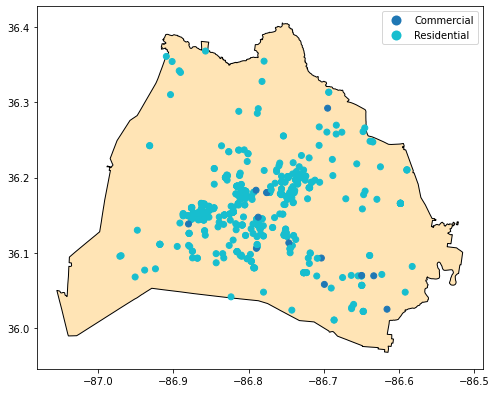

In [18]:
# BLDG PERMIT APPLICATIONS/SUBSET 
# To confirm that all points are within Davidson County

fig, ax = plt.subplots(figsize = (8,8))
df_dav_border.plot(color = 'moccasin', edgecolor = 'black', ax = ax)   # Shows county boarder
df_dav_apps_subset.plot(column = 'category', ax = ax, legend = True)

In [19]:
# BLDG PERMITS ISSUED/SUBSET spatial join with Davidson County 

df_dav_issued_subset = gpd.sjoin(df_bldg_issued_subset_geo, df_dav_border
                                      , op = 'within'      # Keeps ISSUED(L) that are WITHIN the BORDER(R)
                                     )

df_dav_issued_subset.head(2)

,permit_number,permit_type_descr,permit_subtype_descr,date_entered,date_issued,construction_cost,address,city,state,zip,...,lat,lon,category,type_subtype,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len
0,2020032483,Building Residential - New,Single Family Residence,2020-05-26,2020-06-04,185000.0,530 EDWIN ST 22,NASHVILLE,TN,37207,...,36.203789,-86.755262,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,POINT (-86.75526 36.20379),0,525,4,14641027913.6,686109.334953
1,2020008317,Building Residential - New,Single Family Residence,2020-02-06,2020-06-04,290299.0,6982 OLD HICKORY BLVD,WHITES CREEK,TN,37189,...,36.269651,-86.841697,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,POINT (-86.84170 36.26965),0,525,4,14641027913.6,686109.334953


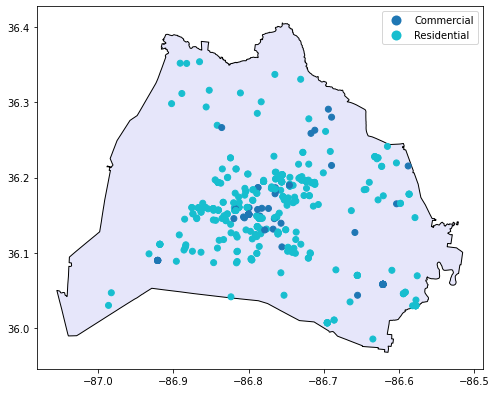

In [20]:
# BLDG PERMIT APPLICATIONS/SUBSET 
# To confirm that all points are within Davidson County

fig, ax = plt.subplots(figsize = (8,8))
df_dav_border.plot(color = 'lavender', edgecolor = 'black', ax = ax)   # Shows county boarder
df_dav_issued_subset.plot(column = 'category', ax = ax, legend = True)

## Adding Neighborhood Assoc 'name' to each row in SUBSETS

In [21]:
# BLDG PERMIT APPLICATIONS SUBSET - Add Neighborhood Assn name to each row
# Testing spatial join to ensure it's going to work as expected.  CONFIRMED
# Commenting it out to prevent notebook bloat.

#gpd.sjoin(df_na_bound_clean, df_dav_apps_subset
#                                  , how = 'right'
#                                  , op = 'intersects'
#                                  , lsuffix = 'boundary'  #Suffix to apply to overlapping column names (left GeoDataFrame)
#                                  , rsuffix = 'apps'      #Suffix to apply to overlapping column names (right GeoDataFrame)
#                                 ).reset_index(drop = True)


In [22]:
# BLDG PERMIT APPLICATIONS SUBSET - Add Neighborhood Assn name to each row
# Goal: Get Neighborhood Assoc name on each row where applicable, otherwise NaN
# Reference info: https://geopandas.org/mergingdata.html#spatial-joins

# pre-generates sindex on df1
df_na_bound_clean.sindex

# polygon df is on left
df_na_and_apps_subset = gpd.sjoin(df_na_bound_clean, df_dav_apps_subset
                                   , how = 'right'
                                   , op = 'intersects'
                                   , lsuffix = 'boundary'  #Suffix to apply to overlapping column names (left GeoDataFrame)
                                   , rsuffix = 'apps'      #Suffix to apply to overlapping column names (right GeoDataFrame)
                                  ).reset_index(drop = True)

# new df added anohter index column. Not sure why, but this drops it.
df_na_and_apps_subset = df_na_and_apps_subset.drop(columns = ['index_boundary'])   

df_na_and_apps_subset.head(2)

,name,permit_number,permit_type_descr,permit_subtype_descr,date_entered,construction_cost,address,city,state,zip,...,lat,lon,category,type_subtype,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len
0,McFerrin Park,T2020034761,Building Residential - New,Single Family Residence,2020-06-04,NaN,518 N 2ND ST,NASHVILLE,TN,37207,...,36.180490,-86.771778,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,POINT (-86.77178 36.18049),0,525,4,14641027913.6,686109.334953
1,McFerrin Park,T2020034763,Building Residential - New,Detached Accessory Dwelling Unit,2020-06-04,NaN,516 2ND ST,NASHVILLE,TN,37207,...,36.180361,-86.771791,Residential,TYPE: Building Residential - New SUBTYPE: Deta...,POINT (-86.77179 36.18036),0,525,4,14641027913.6,686109.334953


In [23]:
# BLDG PERMITS ISSUED SUBSET - Add Neighborhood Assn name to each row
# Testing spatial join to ensure it's going to work as expected.  CONFIRMED
# Commenting it out to prevent notebook bloat.

#gpd.sjoin(df_na_bound_clean, df_dav_issued_subset
#         , how = 'right'
#         , op = 'intersects'
#         , lsuffix = 'boundary'  #Suffix to apply to overlapping column names (left GeoDataFrame)
#         , rsuffix = 'apps'      #Suffix to apply to overlapping column names (right GeoDataFrame)
#        ).reset_index(drop = True)

In [24]:
# BLDG PERMITS ISSUED SUBSET - Add Neighborhood Assn name to each row
# Goal: Get Neighborhood Assoc name on each row where applicable, otherwise NaN
# Reference info: https://geopandas.org/mergingdata.html#spatial-joins

# pre-generates sindex on df1
df_na_bound_clean.sindex

# polygon df is on left
df_na_and_issued_subset = gpd.sjoin(df_na_bound_clean, df_dav_issued_subset
                                   , how = 'right'
                                   , op = 'intersects'
                                   , lsuffix = 'boundary'  #Suffix to apply to overlapping column names (left GeoDataFrame)
                                   , rsuffix = 'apps'      #Suffix to apply to overlapping column names (right GeoDataFrame)
                                  ).reset_index(drop = True)

# new df added anohter index column. Not sure why, but this drops it.
df_na_and_issued_subset = df_na_and_issued_subset.drop(columns = ['index_boundary'])   

df_na_and_issued_subset.head(2)

,name,permit_number,permit_type_descr,permit_subtype_descr,date_entered,date_issued,construction_cost,address,city,state,...,lat,lon,category,type_subtype,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len
0,Highland Heights,2020032483,Building Residential - New,Single Family Residence,2020-05-26,2020-06-04,185000.0,530 EDWIN ST 22,NASHVILLE,TN,...,36.203789,-86.755262,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,POINT (-86.75526 36.20379),0,525,4,14641027913.6,686109.334953
1,Whites Creek,2020008317,Building Residential - New,Single Family Residence,2020-02-06,2020-06-04,290299.0,6982 OLD HICKORY BLVD,WHITES CREEK,TN,...,36.269651,-86.841697,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,POINT (-86.84170 36.26965),0,525,4,14641027913.6,686109.334953


## Doing above steps for FULL dfs:
(Not creating test map, because Permits Issued df has 10k+ rows, too big for marker map)
1. GEODATAFRAMES: Converting to geodataframes
2. DAVIDSON COUNTY: Keeping rows with Points inside Davidson County
3. NEIGHBORHOOD ASSN NAMES: Adding Neighborhood Assn name to each row (or NaN if not in an assoc.)

## 1. GEODATAFRAMES: Converting to geodataframes for FULL dfs

In [25]:
df_bldg_apps_clean.shape   #996 rows

(996, 16)

In [26]:
# SPATIAL JOIN - Before doing spatial joins, all 3 dfs must be converted to geodataframes
# USING SUBSETS of Bldg Permit dfs first (full df for Planning Dept)

# BLDG PERMIT APPLICATIONS/SUBSET to geodataframe
# Convert df into gdf: https://gis.stackexchange.com/questions/147156/making-shapefile-from-pandas-dataframe

# STEP ONE: Create a new geometry column in your dataframe which combines the lat and lon values 
#           into a shapely Point() object. 

df_bldg_apps_clean['geometry'] = df_bldg_apps_clean.apply(lambda x: Point((float(x.lon)
                                                                           , float(x.lat)))
                                                          , axis = 1)

In [27]:
# STEP TWO: Convert the pandas DataFrame into a GeoDataFrame

df_bldg_apps_clean_geo = gpd.GeoDataFrame(df_bldg_apps_clean
                                          , geometry = 'geometry'
                                          , crs = df_na_bound_clean.crs) # Makes CRS match the df I want to join this to later
type(df_bldg_apps_clean_geo)

geopandas.geodataframe.GeoDataFrame

In [28]:
df_bldg_issued_clean.shape

(10433, 17)

In [29]:
# BLDG PERMITS ISSUED/SUBSET to geodataframe
# STEP ONE: Create a new geometry column in your dataframe which combines the lat and lon values 
#           into a shapely Point() object. 

df_bldg_issued_clean['geometry'] = df_bldg_issued_clean.apply(lambda x: Point((float(x.lon)
                                                                               , float(x.lat)))
                                                              , axis = 1)

In [30]:
# STEP TWO: Convert the pandas DataFrame into a GeoDataFrame

df_bldg_issued_clean_geo = gpd.GeoDataFrame(df_bldg_issued_clean
                                            , geometry='geometry'
                                            , crs = df_na_bound_clean.crs)  # Makes CRS match the df I want to join this to later
type(df_bldg_issued_clean_geo)

geopandas.geodataframe.GeoDataFrame

## 3. DAVIDSON COUNTY: Keeping rows with Points inside Davidson County for FULL dfs

In [31]:
# BLDG PERMIT APPLICATIONS/FULL spatial join with Davidson County 

# 1. What do I want geometry column to be after join (it keeps 1st one)
# 2  Use operation that fits as read left to right "blgd apps that are WITHIN dav border"

df_dav_apps = gpd.sjoin(df_bldg_apps_clean_geo, df_dav_border
                        , op = 'within'     # Keeps APPLICATIONS(L) that are WITHIN the BORDER(R)
                       )
print(df_dav_apps.shape)    # New shape 976 (old shape 996, 20 rows were outside davidson county)
df_dav_apps.head(2)

(976, 22)


,permit_number,permit_type_descr,permit_subtype_descr,date_entered,construction_cost,address,city,state,zip,contact,...,lat,lon,category,type_subtype,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len
0,T2020034761,Building Residential - New,Single Family Residence,2020-06-04,NaN,518 N 2ND ST,NASHVILLE,TN,37207,EASTEND CONTRACTING LLC,...,36.180490,-86.771778,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,POINT (-86.77178 36.18049),0,525,4,14641027913.6,686109.334953
1,T2020034763,Building Residential - New,Detached Accessory Dwelling Unit,2020-06-04,NaN,516 2ND ST,NASHVILLE,TN,37207,EASTEND CONTRACTING LLC,...,36.180361,-86.771791,Residential,TYPE: Building Residential - New SUBTYPE: Deta...,POINT (-86.77179 36.18036),0,525,4,14641027913.6,686109.334953


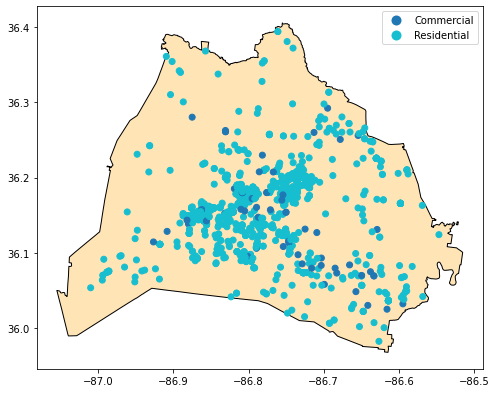

In [32]:
# BLDG PERMIT APPLICATIONS/FULL 
# To confirm that all points are within Davidson County   CONFIRMED

fig, ax = plt.subplots(figsize = (8,8))
df_dav_border.plot(color = 'moccasin', edgecolor = 'black', ax = ax)   # Shows county boarder
df_dav_apps.plot(column = 'category', ax = ax, legend = True)

In [33]:
# BLDG PERMITS ISSUED/FULL spatial join with Davidson County 

df_dav_issued = gpd.sjoin(df_bldg_issued_clean_geo, df_dav_border
                          , op = 'within'      # Keeps ISSUED(L) that are WITHIN the BORDER(R)
                         )
print(df_dav_issued.shape)    # New shape 10265 (old shape 10433, 168 rows were outside davidson county)
df_dav_issued.head(2)

(10265, 23)


,permit_number,permit_type_descr,permit_subtype_descr,date_entered,date_issued,construction_cost,address,city,state,zip,...,lat,lon,category,type_subtype,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len
0,2020032483,Building Residential - New,Single Family Residence,2020-05-26,2020-06-04,185000.0,530 EDWIN ST 22,NASHVILLE,TN,37207,...,36.203789,-86.755262,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,POINT (-86.75526 36.20379),0,525,4,14641027913.6,686109.334953
1,2020008317,Building Residential - New,Single Family Residence,2020-02-06,2020-06-04,290299.0,6982 OLD HICKORY BLVD,WHITES CREEK,TN,37189,...,36.269651,-86.841697,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,POINT (-86.84170 36.26965),0,525,4,14641027913.6,686109.334953


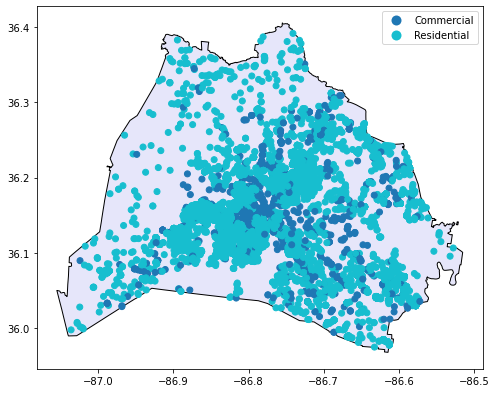

In [34]:
# BLDG PERMIT APPLICATIONS/FULL 
# To confirm that all points are within Davidson County   CONFIRMED

fig, ax = plt.subplots(figsize = (8,8))
df_dav_border.plot(color = 'lavender', edgecolor = 'black', ax = ax)   # Shows county boarder
df_dav_issued.plot(column = 'category', ax = ax, legend = True)

## 3. NEIGHBORHOOD ASSN NAMES: Adding Neighborhood Assn name to each row (or NaN if not in an assoc.) for FULL dfs

In [35]:
df_dav_apps.shape

(976, 22)

In [36]:
%time
# BLDG PERMIT APPLICATIONS FULL - Add Neighborhood Assn name to each row
# Goal: Get Neighborhood Assoc name on each row where applicable, otherwise NaN
# Reference info: https://geopandas.org/mergingdata.html#spatial-joins

# pre-generates sindex on df1
df_na_bound_clean.sindex

# polygon df is on left
# nassoc = neighborhood association, apps = bldg permit applications
df_nassoc_apps = gpd.sjoin(df_na_bound_clean, df_dav_apps   
                           , how = 'right'
                           , op = 'intersects'
                           , lsuffix = 'boundary'  #Suffix to apply to overlapping column names (left GeoDataFrame)
                           , rsuffix = 'apps'      #Suffix to apply to overlapping column names (right GeoDataFrame)
                          ).reset_index(drop = True)

# new df added anohter index column. Not sure why, but this drops it.
df_nassoc_apps = df_nassoc_apps.drop(columns = ['index_boundary'])
df_nassoc_apps.columns

print(df_nassoc_apps.shape)   # RESEARCH: prior shape 976,22. New shape 980,23. How did 4 rows, 1 column get added
df_nassoc_apps.head(2)

Wall time: 0 ns
(980, 23)


,name,permit_number,permit_type_descr,permit_subtype_descr,date_entered,construction_cost,address,city,state,zip,...,lat,lon,category,type_subtype,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len
0,McFerrin Park,T2020034761,Building Residential - New,Single Family Residence,2020-06-04,NaN,518 N 2ND ST,NASHVILLE,TN,37207,...,36.180490,-86.771778,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,POINT (-86.77178 36.18049),0,525,4,14641027913.6,686109.334953
1,McFerrin Park,T2020034763,Building Residential - New,Detached Accessory Dwelling Unit,2020-06-04,NaN,516 2ND ST,NASHVILLE,TN,37207,...,36.180361,-86.771791,Residential,TYPE: Building Residential - New SUBTYPE: Deta...,POINT (-86.77179 36.18036),0,525,4,14641027913.6,686109.334953


In [37]:
print("PERMIT APPLICATIONS, DAVIDSON CNTY: ", df_dav_apps.info())
print("PERMIT APPLICATIONS, DAVIDSON CNTY WITH N.ASSOC. NAME: ", df_nassoc_apps.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 976 entries, 0 to 995
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   permit_number         976 non-null    object  
 1   permit_type_descr     976 non-null    object  
 2   permit_subtype_descr  976 non-null    object  
 3   date_entered          976 non-null    object  
 4   construction_cost     207 non-null    float64 
 5   address               976 non-null    object  
 6   city                  976 non-null    object  
 7   state                 976 non-null    object  
 8   zip                   976 non-null    int64   
 9   contact               976 non-null    object  
 10  ivr_tracking_number   976 non-null    int64   
 11  purpose               972 non-null    object  
 12  lat                   976 non-null    float64 
 13  lon                   976 non-null    float64 
 14  category              976 non-null    object  
 15

In [38]:
%%time
# BLDG PERMITS ISSUED FULL - Add Neighborhood Assn name to each row
# Goal: Get Neighborhood Assoc name on each row where applicable, otherwise NaN
# Reference info: https://geopandas.org/mergingdata.html#spatial-joins

# pre-generates sindex on df1
df_na_bound_clean.sindex

# polygon df is on left
df_nassoc_issued = gpd.sjoin(df_na_bound_clean, df_dav_issued
                             , how = 'right'
                             , op = 'intersects'
                             , lsuffix = 'boundary'  #Suffix to apply to overlapping column names (left GeoDataFrame)
                             , rsuffix = 'apps'      #Suffix to apply to overlapping column names (right GeoDataFrame)
                            ).reset_index(drop = True)

# new df added anohter index column. Not sure why, but this drops it.
df_nassoc_issued = df_nassoc_issued.drop(columns = ['index_boundary'])   

print(df_nassoc_issued.shape)   # RESEARCH: prior shape 10265,23. New shape 10315,24. How did 50 rows 1 column get added
df_nassoc_issued.head(2)

(10315, 24)
Wall time: 676 ms


,name,permit_number,permit_type_descr,permit_subtype_descr,date_entered,date_issued,construction_cost,address,city,state,...,lat,lon,category,type_subtype,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len
0,Highland Heights,2020032483,Building Residential - New,Single Family Residence,2020-05-26,2020-06-04,185000.0,530 EDWIN ST 22,NASHVILLE,TN,...,36.203789,-86.755262,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,POINT (-86.75526 36.20379),0,525,4,14641027913.6,686109.334953
1,Whites Creek,2020008317,Building Residential - New,Single Family Residence,2020-02-06,2020-06-04,290299.0,6982 OLD HICKORY BLVD,WHITES CREEK,TN,...,36.269651,-86.841697,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,POINT (-86.84170 36.26965),0,525,4,14641027913.6,686109.334953


In [39]:
print("PERMITS ISSUED, DAVIDSON CNTY: ", df_dav_issued.info())
print("PERMITS ISSUED, DAVIDSON CNTY WITH N.ASSOC. NAME: ", df_nassoc_issued.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10265 entries, 0 to 10432
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   permit_number         10265 non-null  object  
 1   permit_type_descr     10265 non-null  object  
 2   permit_subtype_descr  10265 non-null  object  
 3   date_entered          10265 non-null  object  
 4   date_issued           10265 non-null  object  
 5   construction_cost     10265 non-null  float64 
 6   address               10265 non-null  object  
 7   city                  10265 non-null  object  
 8   state                 10265 non-null  object  
 9   zip                   10265 non-null  int64   
 10  contact               10265 non-null  object  
 11  ivr_tracking_number   10265 non-null  int64   
 12  purpose               10264 non-null  object  
 13  lat                   10265 non-null  float64 
 14  lon                   10265 non-null  float64 

## To export results 

In [42]:
df_nassoc_apps.to_csv('../data/cleaned/bldg_applications_neighborhoods_davidson_county_new.csv', index = False)
df_nassoc_apps.shape

(980, 23)

In [43]:
df_nassoc_issued.to_csv('../data/cleaned/bldg_issued_neighborhoods_davidson_county_new.csv', index = False)
df_nassoc_issued.shape

(10315, 24)